In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

2024-06-06 15:41:48.880496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 15:41:48.880526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 15:41:48.880537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 15:41:48.924032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-06 15:42:00.757310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 15:42:00.836566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 15:42:00.836739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Define the model

In [3]:
def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = unet_model()

2024-06-06 15:32:12.599291: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2024-06-06 15:32:12.603320: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2024-06-06 15:32:12.606396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2024-06-06 15:32:12.621816: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2024-06-06 15:32:12.629905: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


# Import the images

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tifffile as tif
import matplotlib.pyplot as plt

Folder_SNCA = "/home/hcleroy/PostDoc/Colab_David/ExperimentalData/Processed_Cell_Crops/a-Synuclein_Channel/"
SNCAfiles = ['Cell'+str(i)+'_ROI'+str(i)+'_SNCA.tif' for i in range(1,11)]
Folder_SNCAIP = "/home/hcleroy/PostDoc/Colab_David/ExperimentalData/Processed_Cell_Crops/Synphillin_Channel/"
SNCAIPfiles = ['Cell'+str(i)+'_ROI'+str(i)+'_SNCAIP.tif' for i in range(1,11)]
Folder_path = "/home/hcleroy/PostDoc/Colab_David/ExperimentalData/Processed_Cell_Crops/mask/"
cytoplasms_mask = ['cyt'+str(i)+'.tiff' for i in range(10)]  
condensates_mask = ['cond'+str(i)+'.tiff' for i in range(10)]
cell_mask = ['cell'+str(i)+'.tiff' for i in range(10)]

In [5]:
# Import the snca images
snca = [tif.imread(Folder_SNCA+files) for files in SNCAfiles]
# transform each image into shapes (256,256,1)
snca = [tf.image.resize(stack[:,:,:,np.newaxis],(256,256)) for stack in snca]
# flatten the batch into a single one
snca = np.array([img for stack in snca for img in stack])
# do the same with the cell contour:
cells = [tif.imread(Folder_path+files) for files in cell_mask]
cells = [tf.image.resize(stack[:,:,:,np.newaxis],(256,256)) for stack in cells]
cells = np.array([img for stack in cells for img in stack])


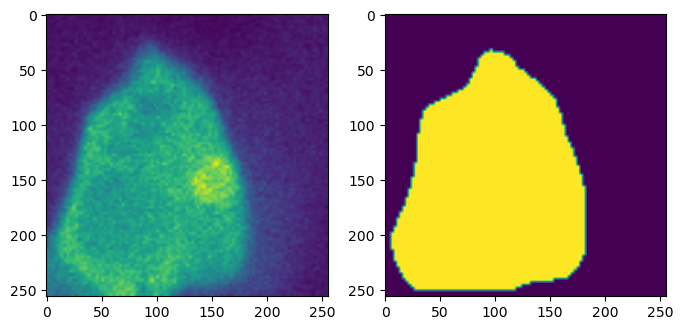

In [27]:
# check that the indexing match
fig,ax = plt.subplots(ncols = 2,figsize=(8,4))
index = 60
ax[0].imshow(snca[index])
ax[1].imshow(cells[index])

In [6]:
history = model.fit(snca, cells, epochs=10, batch_size=1, validation_split=0.2)

Epoch 1/10
 62/116 [===============>..............] - ETA: 2:14 - loss: nan - accuracy: 0.5710

KeyboardInterrupt: 

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Assuming your images and masks are stored in the following directories
#train_images_dir = '/path/to/train/images'
train_images_dir = "/home/hcleroy/PostDoc/Colab_David/ExperimentalData/extracted_frames/contrast_balance_cell_0"
#train_masks_dir = '/path/to/train/masks'
train_masks_dir = "/home/hcleroy/PostDoc/Colab_David/ExperimentalData/extracted_frames/path_cell_0"

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    train_images_dir,
    class_mode=None,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    seed=1
)

mask_generator = mask_datagen.flow_from_directory(
    train_masks_dir,
    class_mode=None,
    target_size=(256, 256),
    batch_size=32,
    color_mode='grayscale',
    seed=1
)

# Combine generators
train_generator = zip(image_generator, mask_generator)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
